# Vehicle Tracking

The project writeup is in-line in this notebook.  I'd recommend watching `debug_output.mp4` from the output folder, since that has multiple deub views showing the pipeline at each step in the process.  The main screen is the final output, top right is the original video, the bottom left are the windows with the detected-car windows highlighted in red, bottom-middle and bottom-right are additional views of which boxes are detected, and the right-middle is the multi-frame heatmap that the boxes are being calculated from.

In [201]:
import numpy as np
import cv2
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import moviepy
import pickle
import pandas as pd
import glob
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label

%matplotlib inline

## Image Loading

Vehicle Examples:  8792
Non-Vehicle Examples:  49959


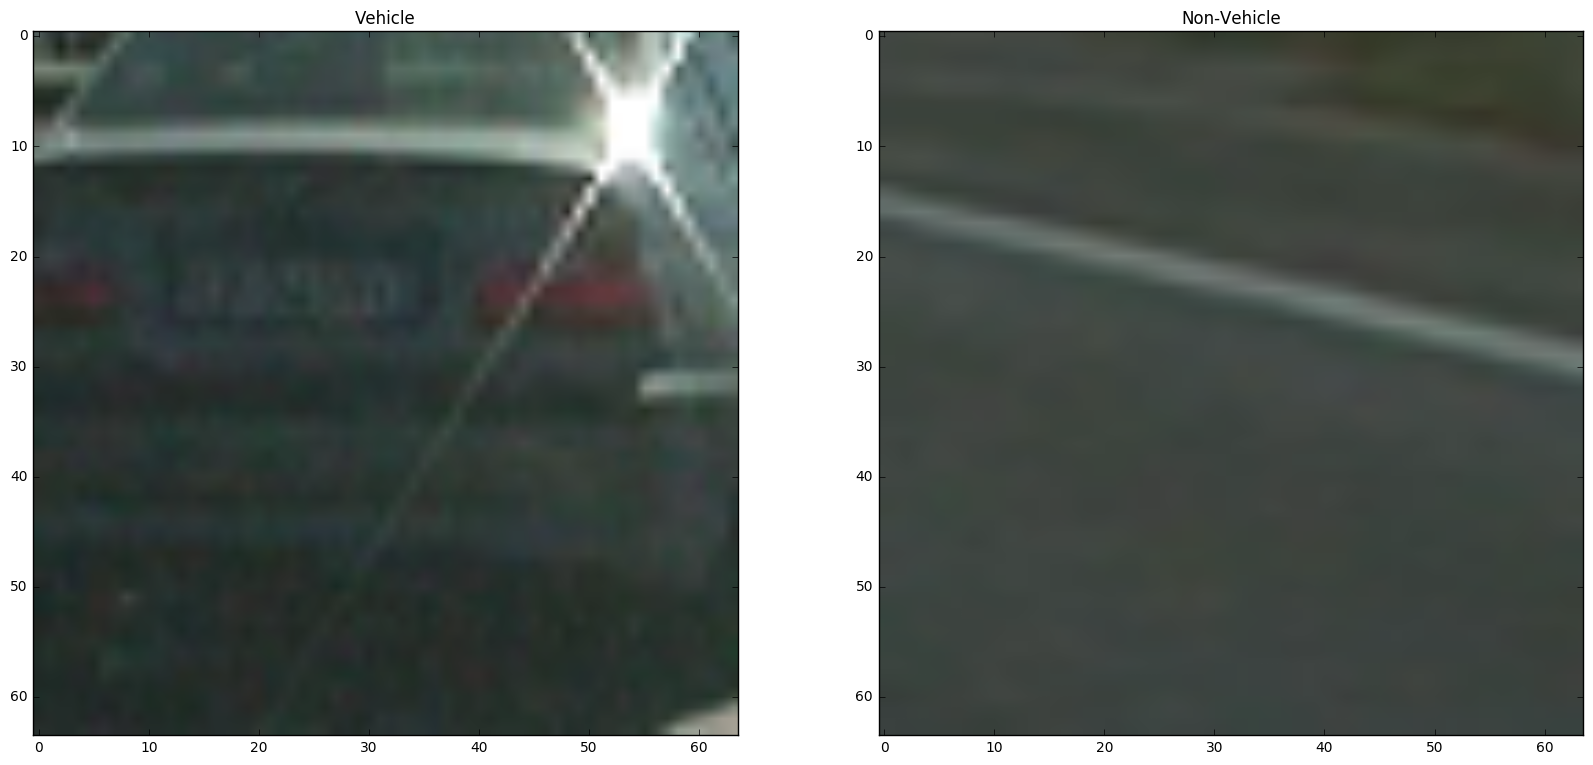

In [177]:
vehicle_files = glob.glob('vehicles/**/*.png')
nonvehicle_files = glob.glob('non-vehicles/**/*.png')
print("Vehicle Examples: ", len(vehicle_files))
print("Non-Vehicle Examples: ", len(nonvehicle_files))

vehicles = [(mpimg.imread(v) * 255).astype(np.uint8) for v in vehicle_files]
nonvehicles = [(mpimg.imread(nv) * 255).astype(np.uint8) for nv in nonvehicle_files]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(vehicles[0])
ax1.set_title('Vehicle')
ax2.imshow(nonvehicles[0])
ax2.set_title('Non-Vehicle')

## HOG Parameter & Feature Selection

I started by manually selecting HOG parameters by altering the parameters and observing the hog images, ultimately selecting the (orient=9, pix_per_cell=8, cell_per_block=2) because the car was still generally recognizable in a variety of color spaces.  I selected the color space to use by training a SVM classifier with each color space, and comparing the results:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Color Space</th>
      <th>Channel</th>
      <th>Extract Time</th>
      <th>Train Time</th>
      <th>Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>RGB</td>
      <td>0</td>
      <td>89.77</td>
      <td>4.78</td>
      <td>0.994043</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RGB</td>
      <td>1</td>
      <td>90.33</td>
      <td>3.94</td>
      <td>0.994298</td>
    </tr>
    <tr>
      <th>2</th>
      <td>RGB</td>
      <td>2</td>
      <td>91.09</td>
      <td>3.68</td>
      <td>0.993277</td>
    </tr>
    <tr>
      <th>3</th>
      <td>RGB</td>
      <td>ALL</td>
      <td>208.33</td>
      <td>6.21</td>
      <td>0.993703</td>
    </tr>
    <tr>
      <th>4</th>
      <td>HSV</td>
      <td>0</td>
      <td>92.93</td>
      <td>11.57</td>
      <td>0.989192</td>
    </tr>
    <tr>
      <th>5</th>
      <td>HSV</td>
      <td>1</td>
      <td>93.73</td>
      <td>9.68</td>
      <td>0.988001</td>
    </tr>
    <tr>
      <th>6</th>
      <td>HSV</td>
      <td>2</td>
      <td>93.53</td>
      <td>4.23</td>
      <td>0.994554</td>
    </tr>
    <tr>
      <th>7</th>
      <td>HSV</td>
      <td>ALL</td>
      <td>211.12</td>
      <td>4.23</td>
      <td>0.995830</td>
    </tr>
    <tr>
      <th>8</th>
      <td>HLS</td>
      <td>0</td>
      <td>92.80</td>
      <td>11.35</td>
      <td>0.987405</td>
    </tr>
    <tr>
      <th>9</th>
      <td>HLS</td>
      <td>1</td>
      <td>93.50</td>
      <td>3.60</td>
      <td>0.993447</td>
    </tr>
    <tr>
      <th>10</th>
      <td>HLS</td>
      <td>2</td>
      <td>92.85</td>
      <td>9.23</td>
      <td>0.988597</td>
    </tr>
    <tr>
      <th>11</th>
      <td>HLS</td>
      <td>ALL</td>
      <td>210.92</td>
      <td>4.16</td>
      <td>0.995575</td>
    </tr>
    <tr>
      <th>12</th>
      <td>YUV</td>
      <td>0</td>
      <td>92.81</td>
      <td>3.75</td>
      <td>0.994383</td>
    </tr>
    <tr>
      <th>13</th>
      <td>YUV</td>
      <td>1</td>
      <td>89.53</td>
      <td>11.36</td>
      <td>0.986044</td>
    </tr>
    <tr>
      <th>14</th>
      <td>YUV</td>
      <td>2</td>
      <td>89.71</td>
      <td>7.55</td>
      <td>0.990128</td>
    </tr>
    <tr>
      <th>15</th>
      <td>YUV</td>
      <td>ALL</td>
      <td>204.26</td>
      <td>3.50</td>
      <td>0.996766</td>
    </tr>
    <tr>
      <th>16</th>
      <td>(Y, Cr, Cb)</td>
      <td>0</td>
      <td>93.19</td>
      <td>3.67</td>
      <td>0.994213</td>
    </tr>
    <tr>
      <th>17</th>
      <td>(Y, Cr, Cb)</td>
      <td>1</td>
      <td>89.28</td>
      <td>7.36</td>
      <td>0.990894</td>
    </tr>
    <tr>
      <th>18</th>
      <td>(Y, Cr, Cb)</td>
      <td>2</td>
      <td>89.38</td>
      <td>11.81</td>
      <td>0.987065</td>
    </tr>
    <tr>
      <th>19</th>
      <td>(Y, Cr, Cb)</td>
      <td>ALL</td>
      <td>203.79</td>
      <td>3.54</td>
      <td>0.997192</td>
    </tr>
  </tbody>
</table>

In my tests, using All YCrCb channels worked the best, with 99.7% accuracy on the initial sample when combined with an RGB histogram.  Once I selected the channels, I hard-coded them in the search function to improve the extraction and training speed.  All features were scaled to zero mean and unit variance before training the classifier.

In [178]:
# These functions are slightly modified from the udacity examples, taking in loaded images instead of paths,
# and adding color features to the extracted features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        color_features = color_hist(image)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, color_features)))
    # Return list of feature vectors
    return features

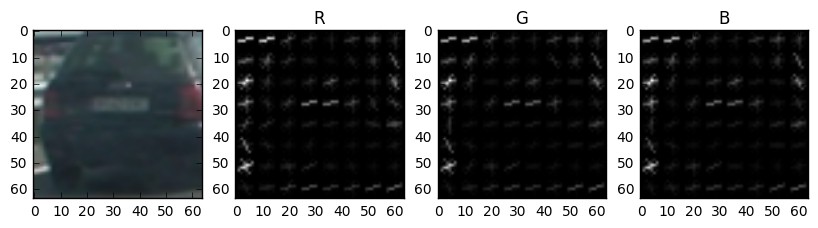

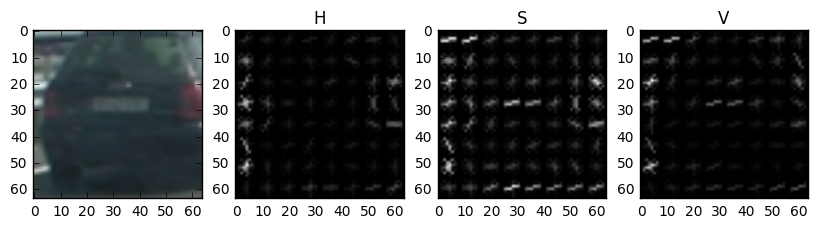

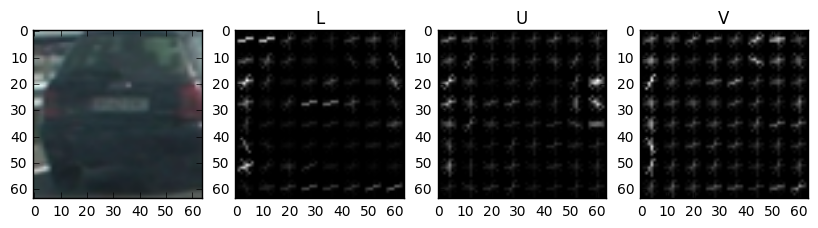

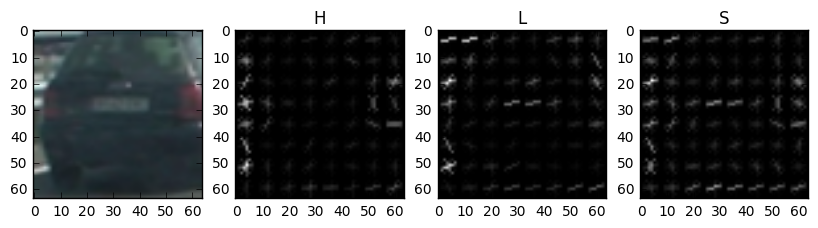

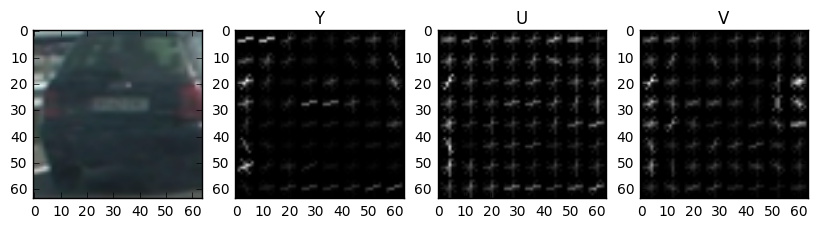

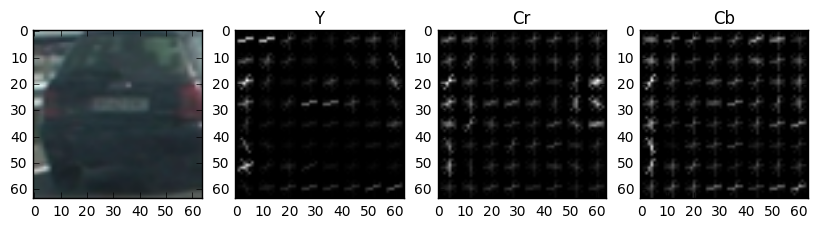

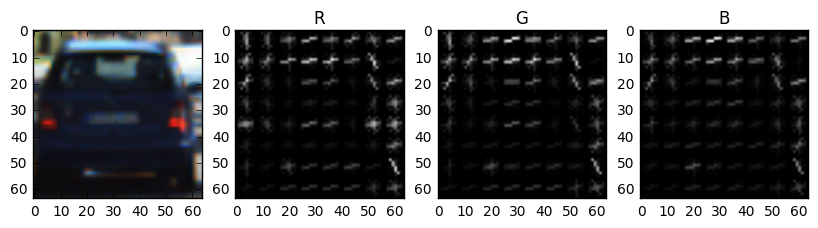

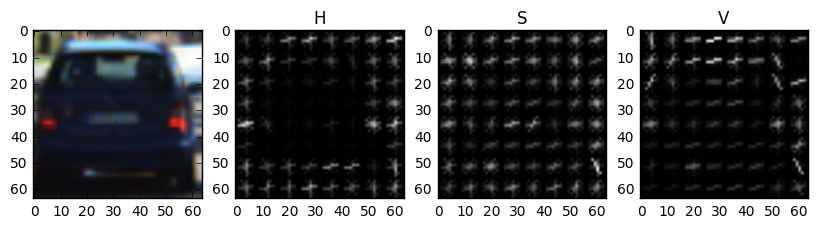

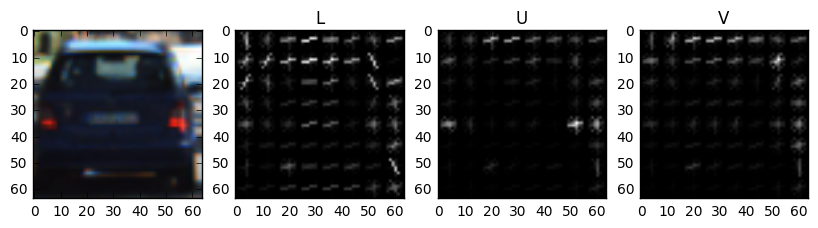

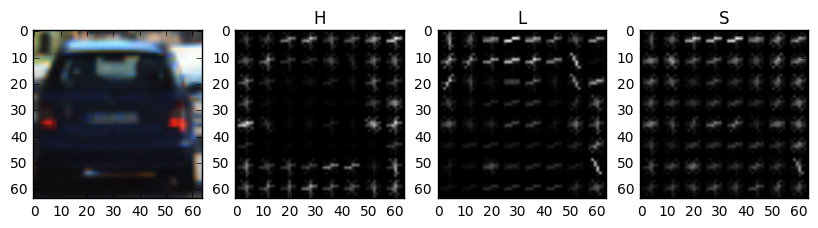

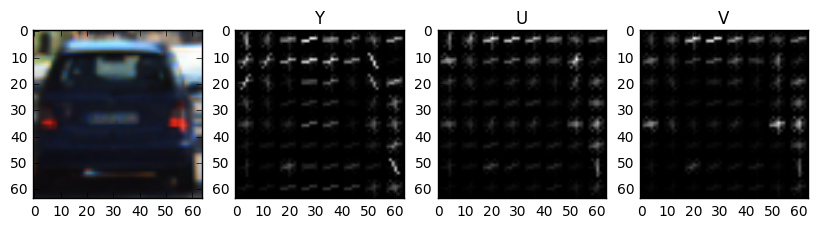

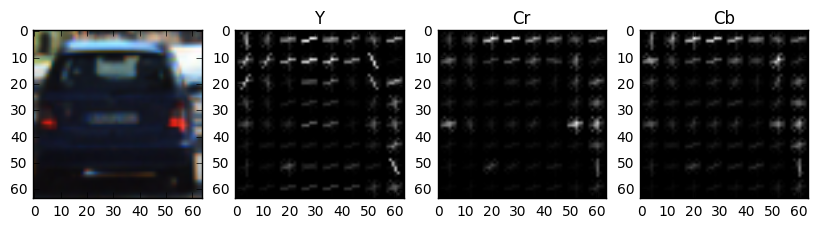

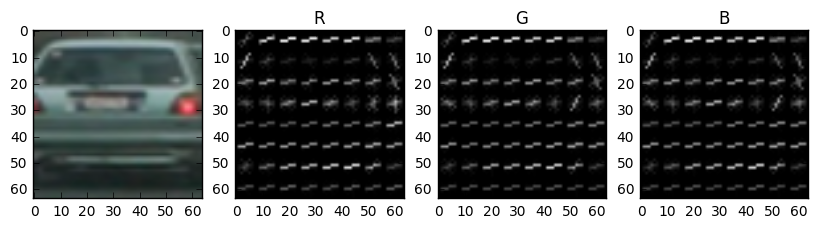

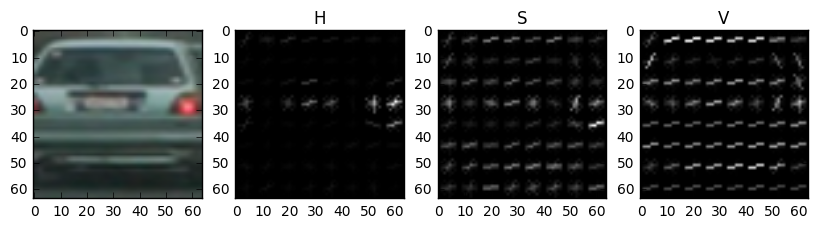

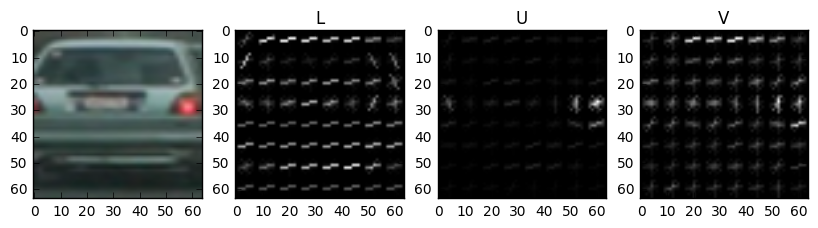

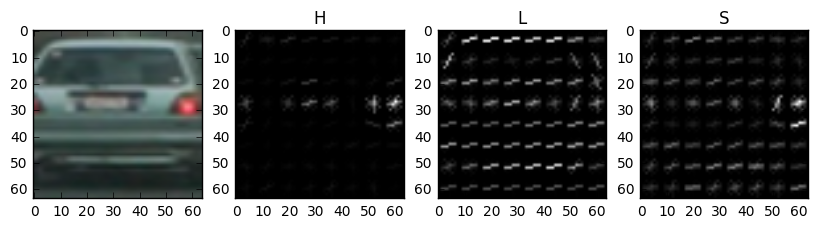

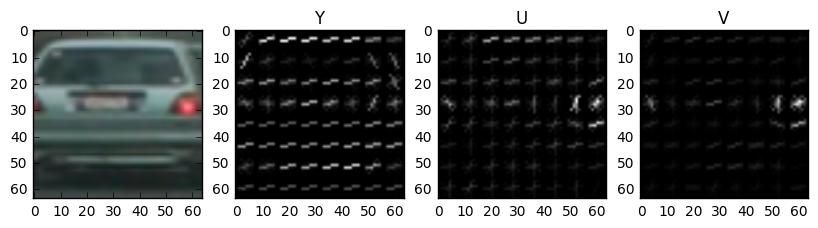

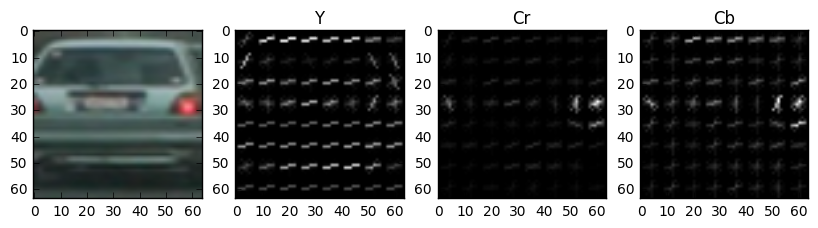

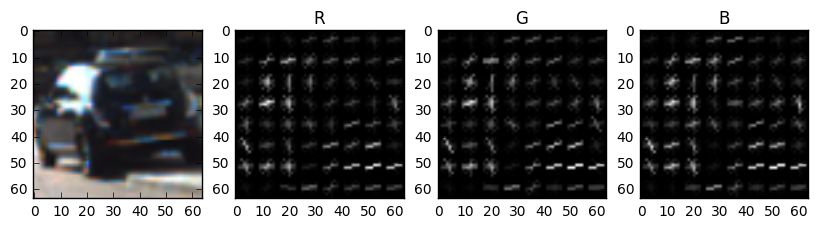

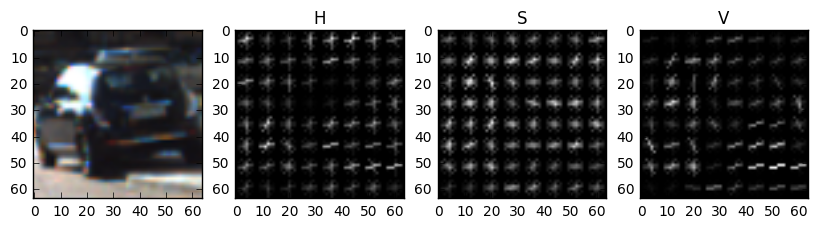

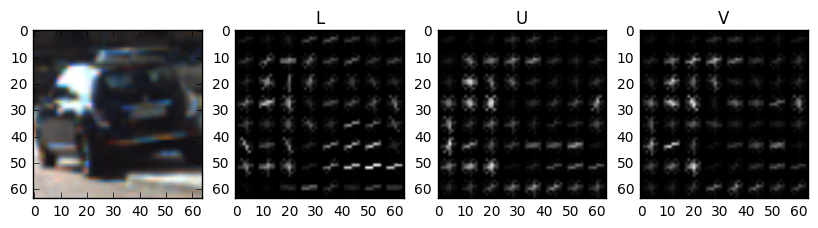

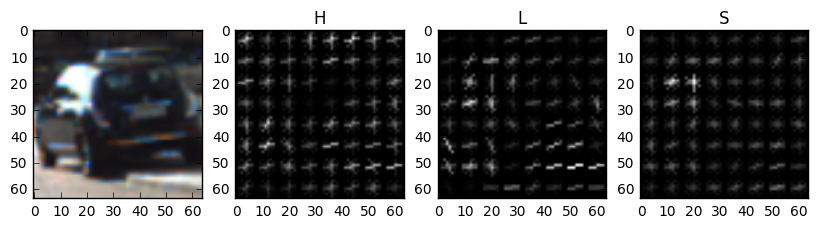

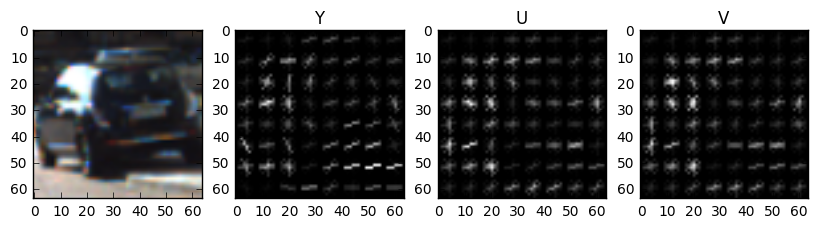

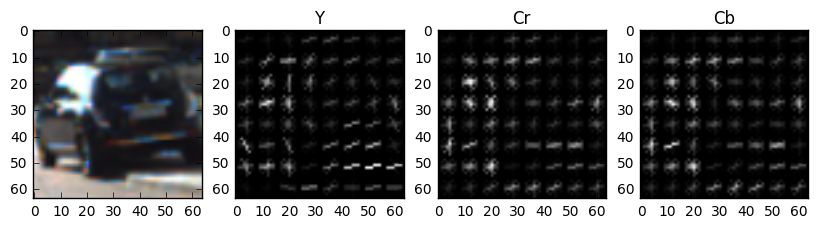

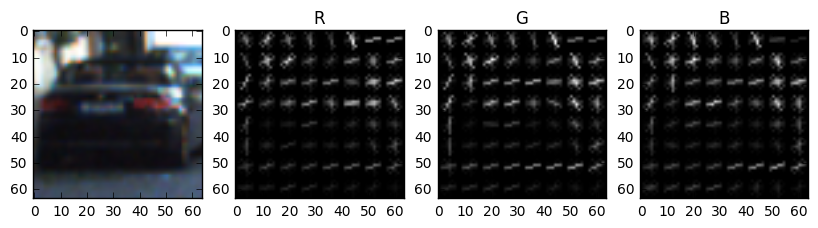

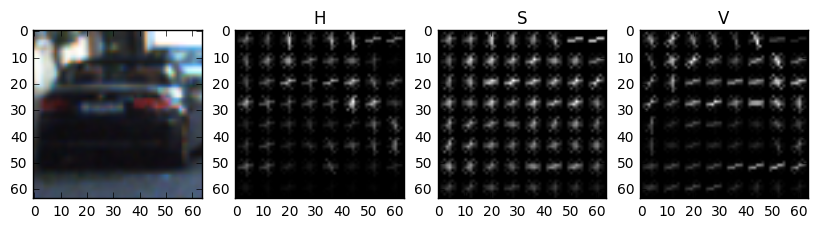

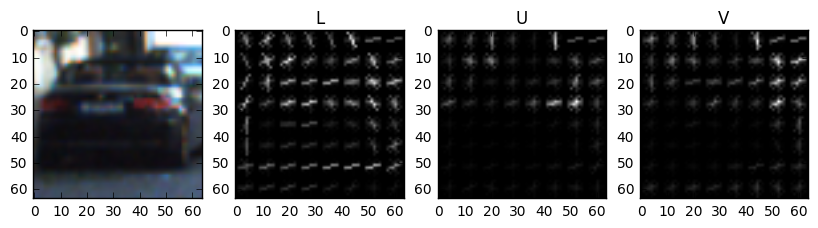

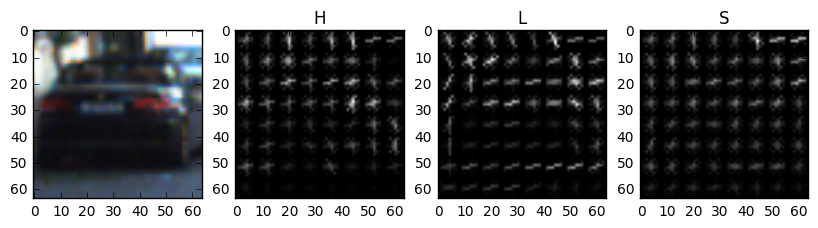

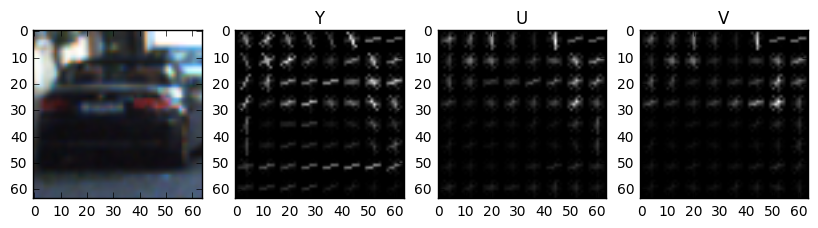

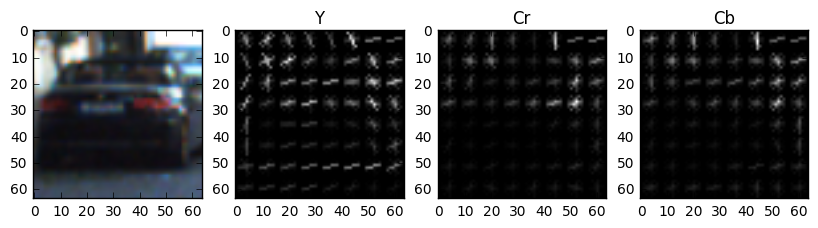

In [294]:
imgs = random.sample(vehicles, 5)

orient=9
pix_per_cell=8
cell_per_block=2

channels = [
    ('RGB', None),
    ('HSV', cv2.COLOR_RGB2HSV),
    ('LUV', cv2.COLOR_RGB2LUV),
    ('HLS', cv2.COLOR_RGB2HLS),
    ('YUV', cv2.COLOR_RGB2YUV),
    (('Y','Cr','Cb'), cv2.COLOR_RGB2YCrCb),
]

color_spaces = [x[0] for x in channels]

for img in imgs:
    for (channel_name, conversion) in channels:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
        ax1.imshow(img)
        
        feature_img = img
        if conversion is not None:
            feature_img = cv2.cvtColor(img, conversion)

        _, hog_image = get_hog_features(feature_img[:,:,0], orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)
        ax2.set_title(channel_name[0])
        ax2.imshow(hog_image, cmap='gray')

        _, hog_image = get_hog_features(feature_img[:,:,1], orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)
        ax3.set_title(channel_name[1])
        ax3.imshow(hog_image, cmap='gray')

        _, hog_image = get_hog_features(feature_img[:,:,2], orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)
        ax4.set_title(channel_name[2])
        ax4.imshow(hog_image, cmap='gray')

In [191]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
seed = 42

params = itertools.product(
    # [x for x in color_spaces if x != 'LUV'], 
    # [0, 1, 2, 'ALL']
    [('Y', 'Cr', 'Cb')],
    ['ALL']
)

results = []
top_score = 0
best_params = None
scaler = None
model = None

# Loop over the parameters, extracting features and training a model for each, saving the best model
for current_params in params:
    color_space, channel = current_params
    color_space_str = ''.join(color_space)
    print("Checking: ", color_space, channel)

    t=time.time()
    car_features = extract_features(vehicles, cspace=color_space_str, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=channel)
    notcar_features = extract_features(nonvehicles, cspace=color_space_str, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=channel)
    t2 = time.time()
    extract_time = round(t2 - t, 2)
    print(extract_time, 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=seed)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    train_time = round(t2 - t, 2)
    print(train_time, 'Seconds to train SVC...')
    
    # Check the score of the SVC
    score = svc.score(X_test, y_test)
    print('Test Accuracy of SVC = ', round(score, 4))
    results.append([color_space, channel, extract_time, train_time, score])
    
    if score > top_score:
        top_score = score
        model = svc
        scaler = X_scaler
        best_params = current_params
    
    print('\n')
    
print("Top Score: ", round(top_score, 4))
print("Using Params: ", best_params)

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

pd.DataFrame(results, columns=['Color Space', 'Channel', 'Extract Time', 'Train Time', 'Score'])

Checking:  ('Y', 'Cr', 'Cb') ALL
309.82 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5388
35.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9957


Top Score:  0.9957
Using Params:  (('Y', 'Cr', 'Cb'), 'ALL')


Color Space Channel  Extract Time  Train Time    Score
0  (Y, Cr, Cb)     ALL        309.82       35.66  0.99566

## Load the model and detect cars

This is just a little helper code to load the model from the saved pickles, and setup a helper function to detect cars in windows of the image.

In [192]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)
    color_space, channel = best_params
    color_space_str = ''.join(color_space)
    
def predict_is_car(img, window_coords):
    """
    Given a window and training coordinates, return True if a car is detected.

    window_coords are tuples of the form (x0, y0, x1, y1).  The minimum value
    was tuned up to 0.7 to reduce false positives.
    """
    x0, y0, x1, y1 = window_coords
    train_img = cv2.resize(img[y0:y1,x0:x1,:], (64,64), interpolation=cv2.INTER_AREA)
    
    features = extract_features([train_img], cspace=color_space_str, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=channel)[0]
    scaled_features = scaler.transform(features)
    return model.decision_function(scaled_features)[0] > 0.7
    

## Sliding Window Search

I implemented a variable-size sliding window search, starting 400 pixels from the top of the image, and 320 pixels from the left, starting with 64 pixel boxes and increasing to 256 pixel boxes, 32 pixels at a time.  I decided the scales and overlap by looking at examples from the video, and selecting a variety that would capture cars close to the foreground well, and would also capture them as they moved away from the camera.  I overlaid the windows on the video and manually tuned this (see debug_output.mp4).

Initially, I was getting many false positives, especially along the left-hand side.  To rectify this, I extracted all of the windows in the first 2 seconds of video and added them to the non-vehicles training set since no vehicles appear during that time - hard-negative mining all of the false positives that appeared during that time.  I was able to get good classification results and minimal false positives after that adjustment.

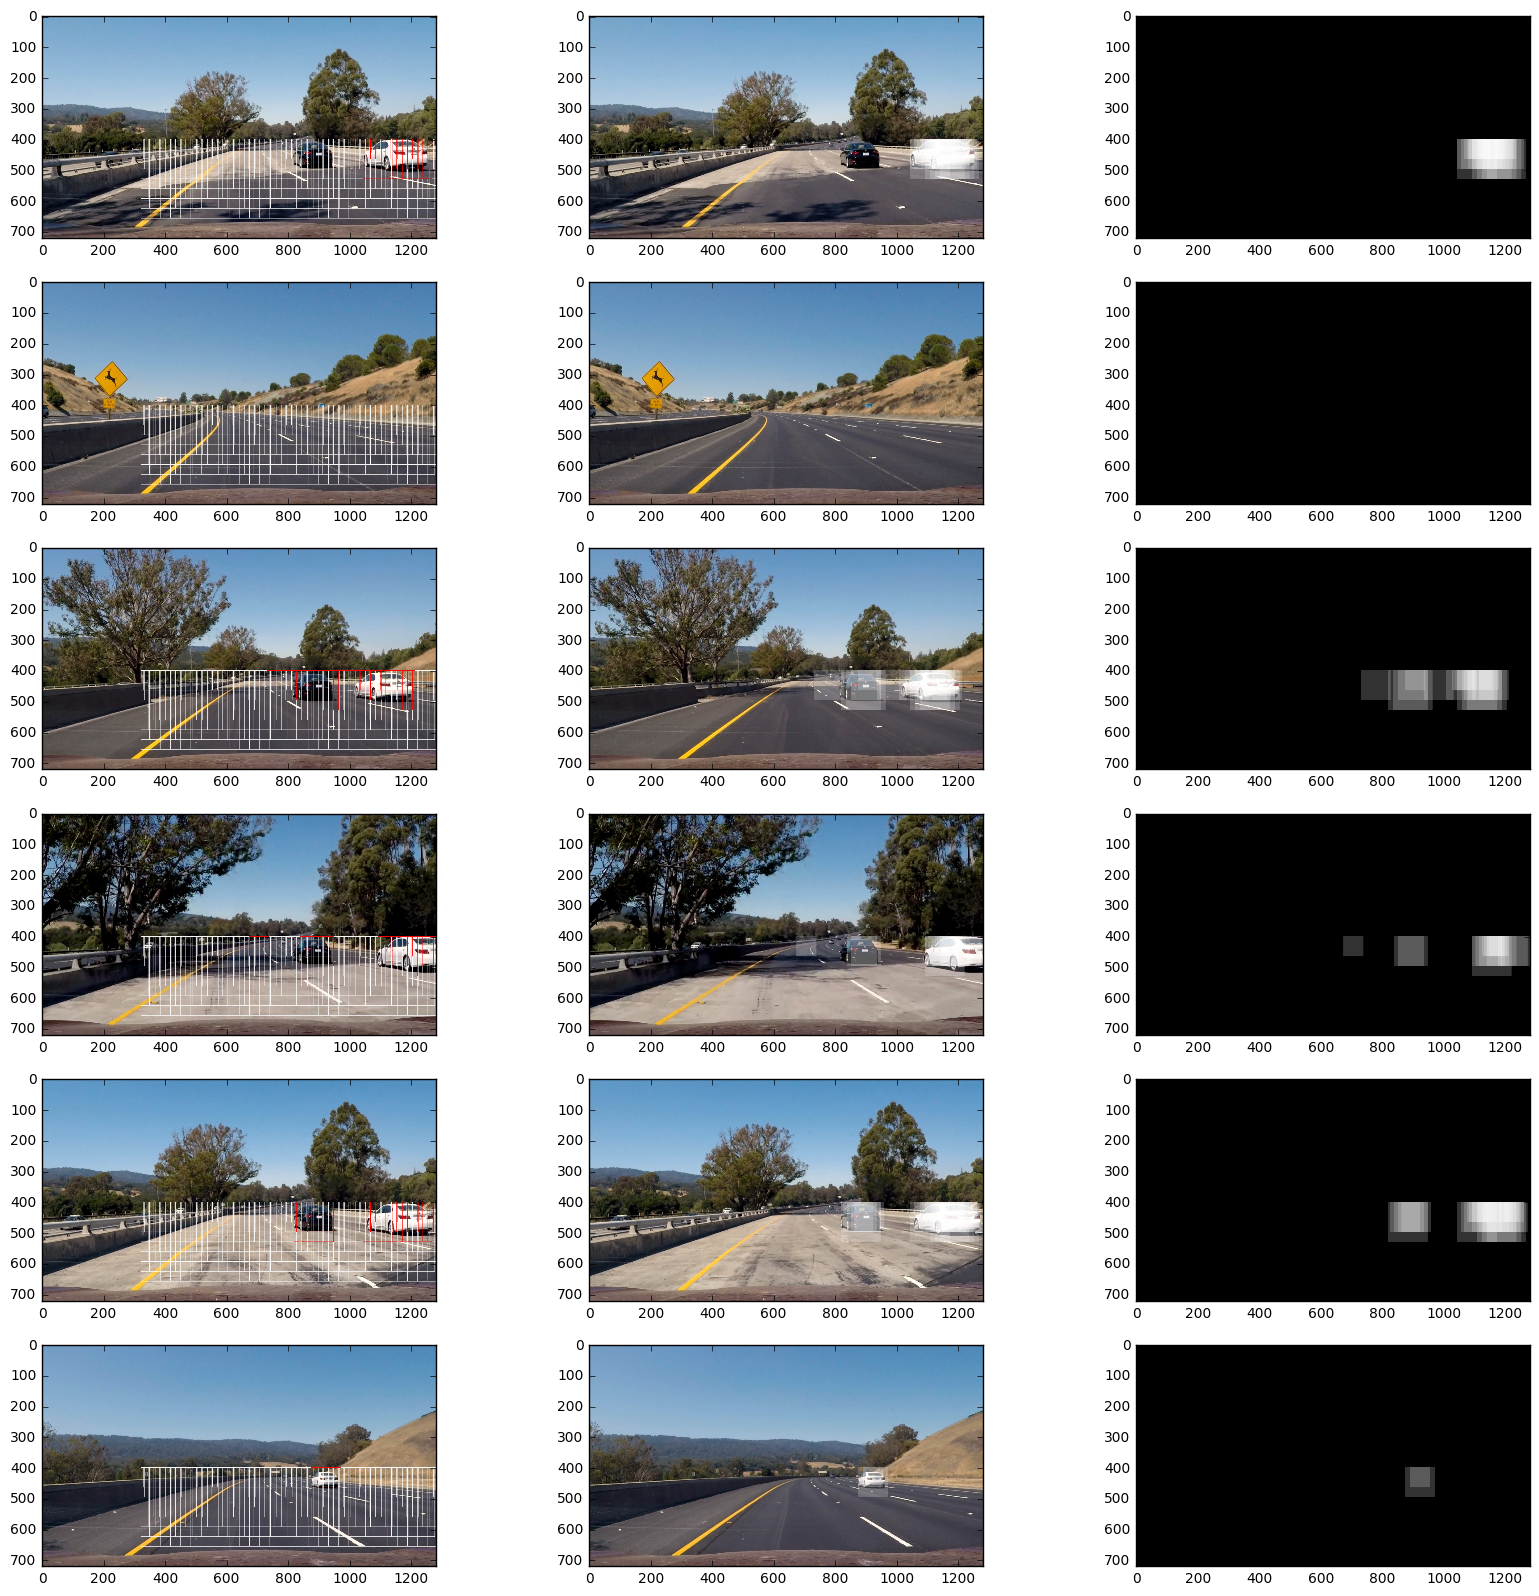

In [193]:
from PIL import Image, ImageDraw

def generate_windows():
    """Yields window tuples of the form (x0, y0, x1, y1)"""
    # 500 - 700, w 300 - 75 offset
    
    def make_windows(top, window_height, left_bound=0, right_bound=1280):
        window_width = window_height
        for x0 in range(left_bound, (right_bound-window_width+1), window_width // 8):
            yield (x0, top, x0 + window_width, top + window_height)
            
    for window_size in range(64, 257, 32):
        for window in make_windows(top=400, window_height=window_size, left_bound=320):
            yield window
        
def draw_windows(pilimg, car_windows=None):
    """Draw windows on the image, highlighting the car windows in red."""
    if car_windows is None:
        car_windows = find_car_windows(img)
    
    pilimg = pilimg.convert('RGBA')
    
    boxes = Image.new('RGBA', pilimg.size, (255,255,255,0))
    draw = ImageDraw.Draw(boxes)
    for window in generate_windows():
        draw.rectangle(window)
        
    for window in car_windows:
        draw.rectangle(window, outline=(255,0,0))
        
    out = Image.alpha_composite(pilimg, boxes)
    return np.asarray(out.convert('RGB'))

def draw_heatmap(pilimg, car_windows=None):
    """Draw a heatmap of car windows on the image, overlaying transparent boxes over each detection."""
    if car_windows is None:
        car_windows = find_car_windows(img)
    
    draw = ImageDraw.Draw(pilimg, 'RGBA')    
    for window in car_windows:
        draw.rectangle(window, fill=(255,255,255,50))
        
    return np.asarray(pilimg)

def draw_black_heatmap(pilimg, car_windows=None):
    """Draw a heatmap of car windows on a black background, overlaying transparent boxes over each detection."""
    if car_windows is None:
        car_windows = find_car_windows(img)
    
    pilimg = Image.new('RGB', pilimg.size)
    
    draw = ImageDraw.Draw(pilimg, 'RGBA')    
    for window in car_windows:
        draw.rectangle(window, fill=(255,255,255,50))
        
    return np.asarray(pilimg.convert('RGB'))

def find_car_windows(img):
    """Search the image for windows containing cars, yielding each window found."""
    for window in generate_windows():
        if predict_is_car(img, window):
            yield window

f, axes = plt.subplots(6, 3, figsize=(20,20))
for idx, path in enumerate(glob.glob('test_images/*.jpg')):
    img = mpimg.imread(path)
    car_windows = list(find_car_windows(img))
    pilimg = Image.fromarray(img)
    axes[idx][0].imshow(draw_windows(pilimg, car_windows))
    axes[idx][1].imshow(draw_heatmap(pilimg, car_windows))
    axes[idx][2].imshow(draw_black_heatmap(pilimg, car_windows))

## Video Implementation

To filter out false positives and combine overlapping windows, I implemented a heatmap matrix.  For every window that I detected a car, I incremented the corresponding heatmap pixels by one, clamping the heatmap to a maximum value of 10.  At every frame, I also decayed the existing heatmap by 1 across the board.  I chose a threshold value of 3 detections at a single pixel to include it in a car box.  This method required multiple overlapping detections, usually over multiple frames, to include a box in the output.

In [291]:
debug = False

class Heatmap(object):
    def __init__(self):
        self.heatmap = np.zeros((720, 1280), dtype=np.int)
        
    def add_car_windows(self, car_windows):
        """Add the detected car windows to the heatmap.
        This function also clips values above 10, and decays
        the heatmap by 1 each frame.
        """
        for window in car_windows:
            x0, y0, x1, y1 = window
            self.heatmap[y0:y1,x0:x1] += 1
            
        self.heatmap = self.heatmap - 1
        self.heatmap[self.heatmap < 0] = 0
        self.heatmap[self.heatmap > 10] = 10
        
    def get_thresholded_heatmap(self):
        """Returns a heatmap containing only values above the threshold"""
        tmap = np.copy(self.heatmap)
        tmap[tmap < 3] = 0
        return tmap
    
    def get_debug_image(self):
        """Returns a debug image, showing the heatmap intensity."""
        out = np.zeros((720, 1280), dtype=np.uint8)
        for i in range(11):
            out[self.heatmap==i] = i * 25
            
        return np.dstack((out, out, out))
        
    def draw_boxes(self, image):
        """Draws blue boxes around each detected car."""
        labels = label(self.get_thresholded_heatmap())
        # From the Udacity example:
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return image
    
    
heatmap = Heatmap()

def process_image(image):        
    """Processes each image in the video, updating the heatmap, and overlaying
    boxes around the detected cars.  Optionally, the entire pipeline is shown in debug
    windows along-side the output.
    """
    car_windows = list(find_car_windows(image))
    heatmap.add_car_windows(car_windows)

    screen = heatmap.draw_boxes(np.copy(image))
        
    if debug:
        debug_screen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        debug_screen[0:720, 0:1280] = screen
        debug_screen[0:360, 1280:1920] = cv2.resize(image, (640,360), interpolation=cv2.INTER_AREA)
        debug_screen[360:720, 1280:1920] = cv2.resize(heatmap.get_debug_image(), (640,360), interpolation=cv2.INTER_AREA)
        
        pilimg = Image.fromarray(image)
        debug_screen[720:1080, 0:640] = cv2.resize(draw_windows(pilimg, car_windows), (640,360), interpolation=cv2.INTER_AREA)
        debug_screen[720:1080, 640:1280] = cv2.resize(draw_heatmap(pilimg, car_windows), (640,360), interpolation=cv2.INTER_AREA)
        debug_screen[720:1080, 1280:1920] = cv2.resize(draw_black_heatmap(pilimg, car_windows), (640,360), interpolation=cv2.INTER_AREA)
    
        Image.fromarray(debug_screen).save('stills/{}.png'.format(process_image.frame))
        screen = debug_screen
    
    process_image.frame = process_image.frame + 1
    return screen

process_image.frame = 0

# Convert the output image
output_video = 'output.mp4'
in_clip = VideoFileClip("project_video.mp4")
out_clip = in_clip.fl_image(process_image)
%time out_clip.write_videofile(output_video, audio=False)

# Show it inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4























  0%|          | 0/1261 [00:00<?, ?it/s]




















  0%|          | 1/1261 [00:02<44:20,  2.11s/it]




















  0%|          | 2/1261 [00:04<44:20,  2.11s/it]




















  0%|          | 3/1261 [00:06<43:52,  2.09s/it]




















  0%|          | 4/1261 [00:08<44:01,  2.10s/it]




















  0%|          | 5/1261 [00:10<43:49,  2.09s/it]




















  0%|          | 6/1261 [00:12<43:54,  2.10s/it]




















  1%|          | 7/1261 [00:14<43:45,  2.09s/it]




















  1%|          | 8/1261 [00:16<43:16,  2.07s/it]




















  1%|          | 9/1261 [00:18<42:54,  2.06s/it]




















  1%|          | 10/1261 [00:20<42:37,  2.04s/it]




















  1%|          | 11/1261 [00:22<42:25,  2.04s/it]




















  1%|          | 12/1261 [00:24<42:18,  2.03s/it]




















  1%|          | 13/1261 [00:26<42:11,  2.03s/it]




















  1%|          | 

[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 42min 36s, sys: 3.23 s, total: 42min 39s
Wall time: 42min 40s


## Conclusion & Discussion

Initially, my classifier was very susceptible to false-negatives, particularly over the yellow line.  By sampling the first 2 seconds of video, where there are no cars to detect, and adding the samples to the non-vehicles set, I was able to almost entirely eliminate these false positives when combined with increasing the "car" threshold from 0.5 to 0.7 for the classifier.  The other major issue is the slow iteration speed.  I could improve that by calculating whole-image hogs at each scale I sample images.  

The pipeline could be significantly improved with a larger training set.  In particular, I added many images to the non-vehicle set, but none to the vehicles set.  The classifier performs well even with the unbalanced set, but vehicle detection could likely be improved with more examples.  I also think it would perform much better with a more sophisticated algorithm like a CNN - while that would be more expensive to train, it may be faster to calculate in real-time, especially with a GPU since the HOG wouldn't need to be taken.  The windows currently don't go all the way to the left, so the pipeline wouldn't work for videos where the car isn't driving in the left-lane, but that would be very easy to adjust, and wouldn't impact the classification on this video (but would impact the runtime).

Overall, this classifier won't generalize very well.  The algorithm can't learn non-linear features, and cars come in enough varieties that the ability to learn these features would likely be very important to generalizing to a variety of vehicle types, sizes, and orientations.

Finally, there is one false positive, and the heatmap code could be better tuned to follow the cars more accurately and closely.  I chose not to do this because of the very long iteration cycle.